# TSL Timing Screen Screenshot Grabber

A simple script to grab a screenshot of a TSL Timing screen.

*Note that the recipe is easily generalised to grab arbitrary webpages.*

In [1]:
#Inspired by: https://www.kaggle.com/dierickx3/kaggle-web-scraping-via-headless-firefox-selenium
#from webdriverdownloader import GeckoDriverDownloader
#gdd = GeckoDriverDownloader()
#geckodriver, geckobin = gdd.download_and_install("v0.23.0")

#Alternatively, we can install as part of the container build process

## Set up a browser instance

We can create a headless browser (one that doesn't need to open in a window that we can see) that we can load pages into and grab screenshots from. As we are running an actual browser, if the web page is being updated via a websocket connection, our remotely launched browser will be being updated with the socket connection data.

So once we lauch our browser onto a timing screen, we can just keep referencing the browser to get the latest view of the page...

In [75]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

options = Options()
options.headless = True

#If we need to set the path to geck, we can...
#browser = webdriver.Firefox(executable_path=geckobin, options=options)

browser = webdriver.Firefox(options=options)

Set the URL of the page you want to grab the screenshot for:

In [81]:
url = "https://livetiming.tsl-timing.com/191231"
url = 'https://livetiming.tsl-timing.com/191209'
url='https://livetiming.tsl-timing.com/191431'#brscc april 6
#url='https://livetiming.tsl-timing.com/191403' #btcc april 6
url='https://livetiming.tsl-timing.com/191521' #croft barc april 13

Some web pages take time to load. For example, the TSL live timing screens are likely to show a spinny thing when a timing screen page is first loaded.

*The TSL timing screen works by loading a page container, then sets up a data connection via a web socket to retrieve the actual timing updates. If we are just grabbing a screenshot of the rendered timing screen, we need to make sure we wait long enough for the spinny thing to disappear and for the table to be rendered.*

In [82]:
#desiredId = 'tablebody' #The HTML id of a tag we want to be visible before we grab the page screenshot
undesiredId = 'loading' #The HTML tag of an element we want to be invisible before we grab the page screenshot

Set the name of the image file you want to save the screenshot to:

In [83]:
outfile = 'screenshot.png'

Now we can grab the screenshot:

In [84]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

In [85]:
#Set a default screensize...
#There are other ways of setting up the browser so that we can grab the full browser view,
#even long pages that would typically require scrolling to see completely
browser.set_window_size(800, 400)
browser.get(url)

#EC.visibility_of_element_located
#EC.presence_of_element_located
#EC.invisibility_of_element_located

#Let's wait for the spinny thing to disappear...
element = WebDriverWait(browser, 10).until( EC.invisibility_of_element_located((By.ID, undesiredId)))

#Save the page
browser.save_screenshot( outfile )
print('screenshot saved to {}'.format(outfile))

screenshot saved to screenshot.png


Preview the captured page:

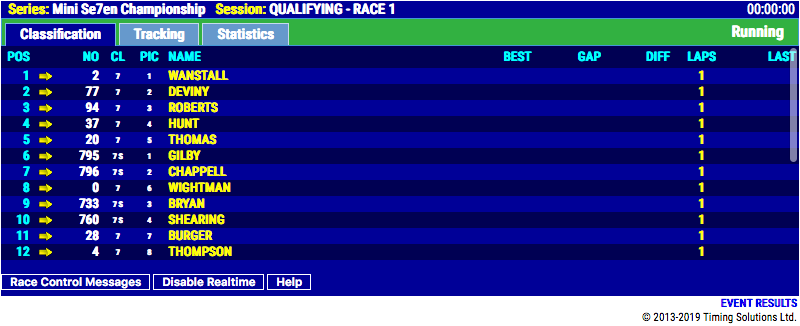

In [86]:
from IPython.display import Image
Image(outfile)

In [114]:
from selenium.common.exceptions import TimeoutException

#This will return something if it loads within the specified maxwait
def initBrowser(url, maxwait=10):
    ''' Launch a new browser and '''
    browser = webdriver.Firefox(options=options)
    browser.get(url)
    
    try:
        element = WebDriverWait(browser, maxwait).until( EC.invisibility_of_element_located((By.ID, undesiredId)))
    except TimeoutException as e:
        browser.close()
        return None

    return browser


#Note that we can also reload a page (ctrl-R) with:
#browser.refresh()

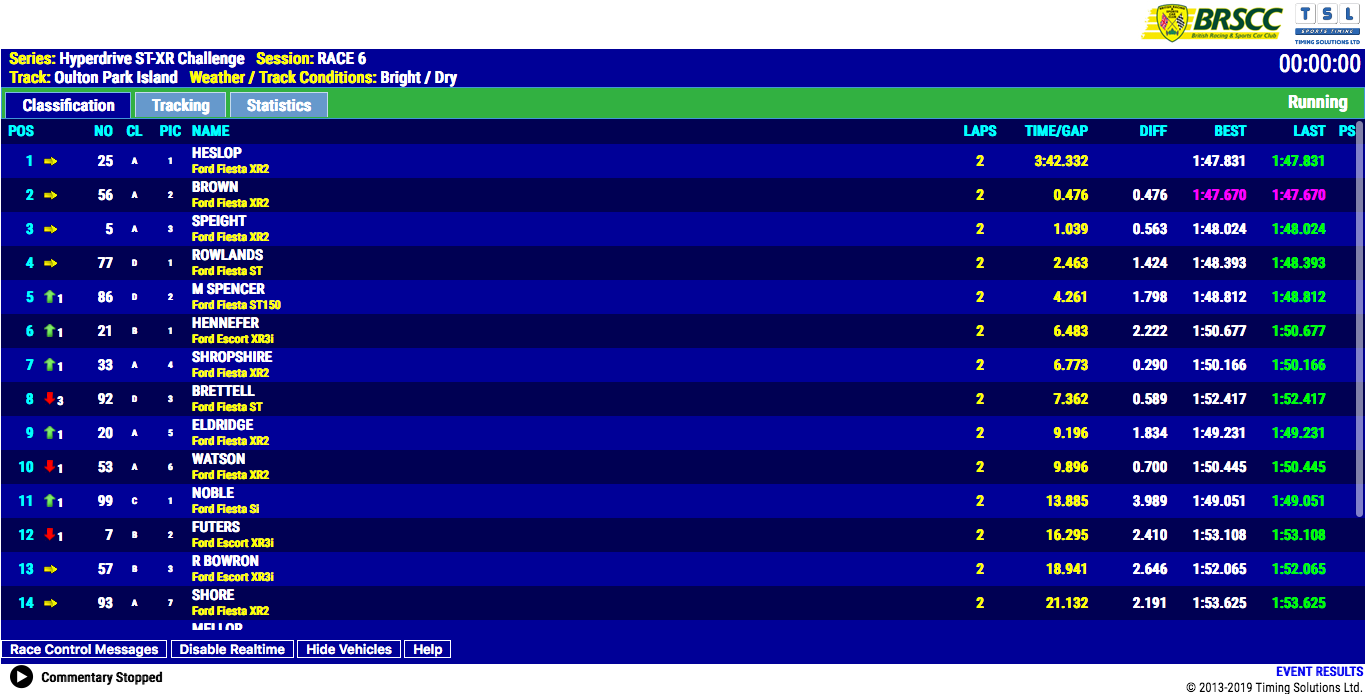

In [122]:
browser=initBrowser(url)
browser.save_screenshot( outfile )
Image(outfile)

## Tabs

- Classification: current ranking
- Tracking: track map
- Weather:
- Statistics: fasest laps etc

We can also grab other tabs...

screenshot saved to screenshot_Classification.png


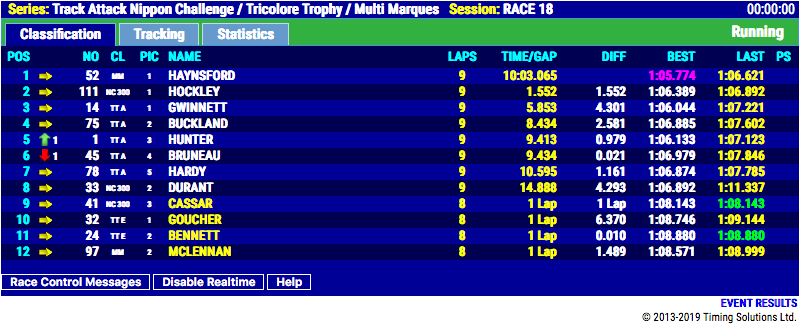

In [9]:
#Classification, Weather, Statistics

tabId = "Classification"
element = browser.find_element_by_id(tabId)
element.click()
element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))

ofn = '{}_{}.png'.format(outfile.replace('.png',''),tabId)

#Save the page
browser.save_screenshot( ofn )
print('screenshot saved to {}'.format(ofn))
Image(ofn)

### Grab some metadata

The timing screen includes information about the race series and the session the timing screen relates to. We can pull that data out of the timing screen to act as metadata.

In [203]:
#https://stackoverflow.com/a/12150013/454773
from selenium.common.exceptions import NoSuchElementException

def check_exists_by_xpath(driver, xpath):
    try:
        driver.find_element_by_xpath(xpath)
    except NoSuchElementException:
        return False
    return True

def text_value_from_xpath(driver, xpath):
    try:
        el = driver.find_element_by_xpath(xpath)
    except NoSuchElementException:
        return ''
    return el.text

#check_exists_by_xpath(browser, '//*[@id="currentflag"]')

In [11]:
#Let's use the classification screen as our "base" screen
tabId='Classification'
element = browser.find_element_by_id(tabId)
element.click()
element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))


Get the series name:

In [12]:
series_path='//*[@id="seriesName"]/span[2]'

series = text_value_from_xpath(browser, series_path)
series

'Track Attack Nippon Challenge / Tricolore Trophy / Multi Marques'

And the session:

In [13]:
session_path = '//*[@id="sessionName"]/span[2]'
session = text_value_from_xpath(browser, session_path )
session

'RACE 18'

We could use this information to give us meaningful filenames when we save timing screen images or data.

In [14]:
#Red flag
#//*[@id="currentflag"]
flag_path='//*[@id="currentflag"]'
flag = text_value_from_xpath(browser, flag_path )
flag

'Running'

In [15]:
sessionTime_path ='//*[@id="sessionTime"]'
sessionTime = text_value_from_xpath(browser, sessionTime_path )
sessionTime

'00:00:00'

In [202]:
def tableNameCleaner(t):
    if t:
        t = t.replace('/','').replace(' - ','_').replace('-','_').replace(' ','_').upper()
        t = t.replace('QUALIFYING','Q').replace('RACE','R').replace('CHAMPIONSHIP','')
    return t
    
def getInfo(browser):
    series_path='//*[@id="seriesName"]/span[2]'
    series = text_value_from_xpath(browser, series_path)
    
    session_path = '//*[@id="sessionName"]/span[2]'
    session = text_value_from_xpath(browser, session_path )

    return {'series':series,
            'session':session,
             'tablename': tableNameCleaner('{}_{}'.format(series,session)) }

In [194]:
 getInfo(browser)

{'series': 'Northern Saloons and Sports Car Championship',
 'session': 'QUALIFYING - RACE 5',
 'tablename': 'NORTHERN_SALOONS_AND_SPORTS_CAR__Q_R_5'}

### Grabbing Images of the Timing Screen

We can create a simple function to use *selenium* to grab png screenshots of a particular tab on the timing screen.

In [147]:
def setPageTab(browser, tabId='Classification', ofn=None, preview=True):
    ''' Simple function to view a particular tab within a TSL timing screen. '''
    #ofn is output filename
    element = browser.find_element_by_id(tabId)
    element.click()
    element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))

    ofn = ofn if ofn is not None else '{}_{}.png'.format(outfile.replace('.png',''),tabId)

    if preview:
        #Save the page
        browser.save_screenshot( ofn )
        print('screenshot saved to {}'.format(ofn))
        display(Image(ofn))

        return ofn

screenshot saved to screenshot_Classification.png


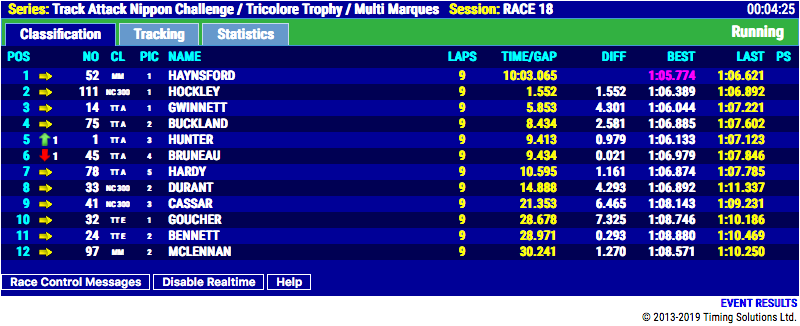

'screenshot_Classification.png'

In [18]:
#url = 'https://livetiming.tsl-timing.com/191209'
setPageTab(browser,'Classification')

We could create a meaningful filename from the series and session metadata. For example:

screenshot saved to Track Attack Nippon Challenge _ Tricolore Trophy _ Multi Marques_RACE 18.png


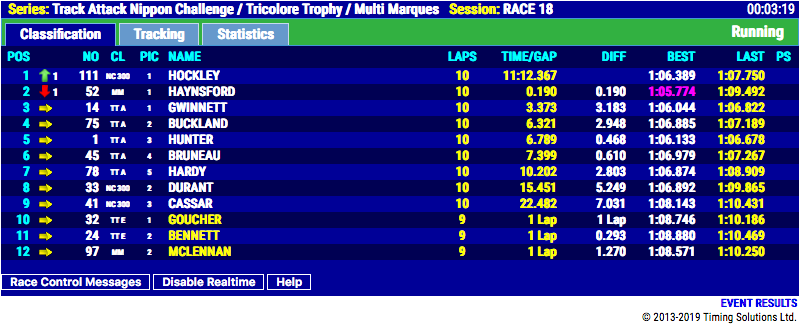

'Track Attack Nippon Challenge _ Tricolore Trophy _ Multi Marques_RACE 18.png'

In [23]:
#get file name
fn = '{}_{}.png'.format(series.replace('/','_'), session.replace('/','_') )

setPageTab(browser, 'Classification', fn)

We can get also access to the actual HTML via the element's `innerHTML()` attribute:

`el.get_attribute('innerHTML')`

If we grab the `<table>` element, this actually returns the contents contained *within* the table element, so we would need to recreate the outer `<table>` tag before we try to scrape the table data into a *pandas* dataframe. If we grab a `<div>` element that contains the table, we can scrape it directly into a *pandas* dataframe.

In [261]:
#classification data
xpath = '//*[@id="ResultsTableContainer"]'
el = browser.find_element_by_xpath(xpath)

In [262]:
import pandas as pd

df = pd.read_html( el.get_attribute('innerHTML'))[0].dropna(axis=1,how='all')
df.rename(columns={'Time/Gap':'TimeGap',
                   'Unnamed: 1':'Penalties'}, inplace=True)
df.head()

,Pos,Penalties,No,Cl,PIC,Name,Laps,TimeGap,Diff,Best,Last,PS
0,1,Penalties +0 seconds +0 position +0 lap +0...,48,Mig,1,DEEGAN Mini Miglia 1275,13,20:36.644,NaN,1:33.705,1:34.377,NaN
1,2,Penalties +0 seconds +0 position +0 lap +0...,1,Mig,2,SMITH Mini Miglia 1293,13,0.354,0.354,1:33.789,1:34.779,NaN
2,3,Penalties +0 seconds +0 position +0 lap +0...,11,Mig,3,ASTIN Mini Miglia 1293,13,2.501,2.147,1:33.865,1:35.275,NaN
3,4,Penalties +0 seconds +0 position +0 lap +0...,23,Mig,4,DEETH Mini Miglia 1293,13,4.260,1.759,1:34.438,1:34.438,NaN
4,5,Penalties +0 seconds +0 position +0 lap +0...,83,Mig,5,PEACOCK Mini Miglia 1293,13,4.712,0.452,1:34.171,1:34.598,NaN


In [263]:
df.dtypes

Pos            int64
Penalties     object
No             int64
Cl            object
PIC            int64
Name          object
Laps           int64
TimeGap       object
Diff          object
Best          object
Last          object
PS           float64
dtype: object

We also need to get the flag status. This is on path `//*[@id="tablebody"]/tbody/tr[3]/td[2]/div[1]`

In [264]:
browser=initBrowser(url)

In [265]:
els = browser.find_elements_by_xpath('//*[@id="tablebody"]/tbody/tr[*]/td[2]/div[1]')
for el in els:
    print(el.get_attribute("class").split(' ')[-1])

posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconFinished
posIconMissing
posIconMissing
posIconBlank
posIconMissing
posIconBlank


Let's make a function for that:

In [266]:
def getPosIcon(browser):
    els = browser.find_elements_by_xpath('//*[@id="tablebody"]/tbody/tr[*]/td[2]/div[1]')
    icons=[]
    for el in els:
        icons.append(el.get_attribute("class").split(' ')[-1])
    return pd.DataFrame({'icons':icons})

getPosIcon(browser)

,icons
0,posIconFinished
1,posIconFinished
2,posIconFinished
3,posIconFinished
4,posIconFinished
5,posIconFinished
6,posIconFinished
7,posIconFinished
8,posIconFinished
9,posIconFinished


In [267]:
df['icons'] = getPosIcon(browser)['icons']
df

,Pos,Penalties,No,Cl,PIC,Name,Laps,TimeGap,Diff,Best,Last,PS,icons
0,1,Penalties +0 seconds +0 position +0 lap +0...,48,Mig,1,DEEGAN Mini Miglia 1275,13,20:36.644,NaN,1:33.705,1:34.377,NaN,posIconFinished
1,2,Penalties +0 seconds +0 position +0 lap +0...,1,Mig,2,SMITH Mini Miglia 1293,13,0.354,0.354,1:33.789,1:34.779,NaN,posIconFinished
2,3,Penalties +0 seconds +0 position +0 lap +0...,11,Mig,3,ASTIN Mini Miglia 1293,13,2.501,2.147,1:33.865,1:35.275,NaN,posIconFinished
3,4,Penalties +0 seconds +0 position +0 lap +0...,23,Mig,4,DEETH Mini Miglia 1293,13,4.260,1.759,1:34.438,1:34.438,NaN,posIconFinished
4,5,Penalties +0 seconds +0 position +0 lap +0...,83,Mig,5,PEACOCK Mini Miglia 1293,13,4.712,0.452,1:34.171,1:34.598,NaN,posIconFinished
5,6,Penalties +0 seconds +0 position +0 lap +0...,80,Mig,6,THOMPSON Mini Miglia 1300,13,6.934,2.222,1:34.600,1:35.371,NaN,posIconFinished
6,7,Penalties +0 seconds +0 position +0 lap +0...,45,Mig,7,MORGAN Mini Miglia 1293,13,16.673,9.739,1:34.924,1:36.173,NaN,posIconFinished
7,8,Penalties +0 seconds +0 position +0 lap +0...,92,Mig,8,PORTER Mini Miglia 1293,13,17.047,0.374,1:35.003,1:35.154,NaN,posIconFinished
8,9,Penalties +0 seconds +0 position +0 lap +0...,20,Mig,9,SIMS Mini Miglia 1293,13,30.398,13.351,1:36.101,1:36.198,NaN,posIconFinished
9,10,Penalties +0 seconds +0 position +0 lap +0...,85,Mig,10,SUMMERHAYES Mini Miglia 1293,13,31.238,0.840,1:35.313,1:36.356,NaN,posIconFinished


In [301]:
#Create this as a temporary table for a particular session
#Then think about merging into to a full table overal sessions / events etc

classification_table = '''
CREATE TABLE IF NOT EXISTS  "{_table}" (
  "Pos" INTEGER,
  "Penalties" TEXT,
  "Icons" TEXT,
  "No" INTEGER,
  "Cl" TEXT,
  "PIC" INTEGER,
  "Name" TEXT,
  "Laps" INTEGER,
  "Gap" TEXT,
  "Diff" TEXT,
  "Best" TEXT,
  "BestInS" FLOAT,  
  "Last" TEXT,
  "LastInS" FLOAT,
  "PS" FLOAT,
  "S1" TEXT,
  "V1" FLOAT,
  "S2" TEXT,
  "V2" FLOAT,
  "S3" TEXT, 
  "VF" FLOAT,
  PRIMARY KEY (No, Laps) ON CONFLICT IGNORE
);
'''

#PK WITH LAST, OR TIMEGAP??? Or just go with Number/Lap PK the first time we get that combination
#dan then ignore any updates to it?
#Rather that upsert, just do an insert, so we only get new Number/Laps combinations?

In [197]:
import sqlite3
from sqlite_utils import Database

dbname='new_testlive.db'

#!rm $dbname
conn = sqlite3.connect(dbname, timeout=10)

_table = 'tsl_timing_classification'

#Setup database tables
c = conn.cursor()
c.executescript(classification_table.format(_table=_table))


DB = Database(conn)


If we grab the classification table with a period slightly less than that of the fastest sector time, and upsert on the table using the (car number, lap, gap) as a unique key, then we should make sure we capture all the laps and the sector times, though we will need to do a little bit of processing of the multiple rows captured for each driver for each lap. (As the timing screen is live, as the leader goes onto a new lap, every other driver goes at least 1 Lap behind; we have to recover from such things.)

The *(car number, lap, previous lap)* combination should also be unique. (I need to think, would that guarantee we capture section times?).

My original method used upserts to prevent collisions, but that's wrong, I think. SQLite lets us add a condirtion to the PK in a table definition that will ignore conflicts, so we can add a car number / lap combination to the tabe as soon as we see it, and then if we upload it again, perhaps with the `TimeGap` reset to `Lap 1` by the lead car starting a new lap, we can just ignore it.

In [91]:
url = 'https://livetiming.tsl-timing.com/191521'
browser = webdriver.Firefox(options=options)
browser.get(url)

screenshot saved to screenshot_Classification.png


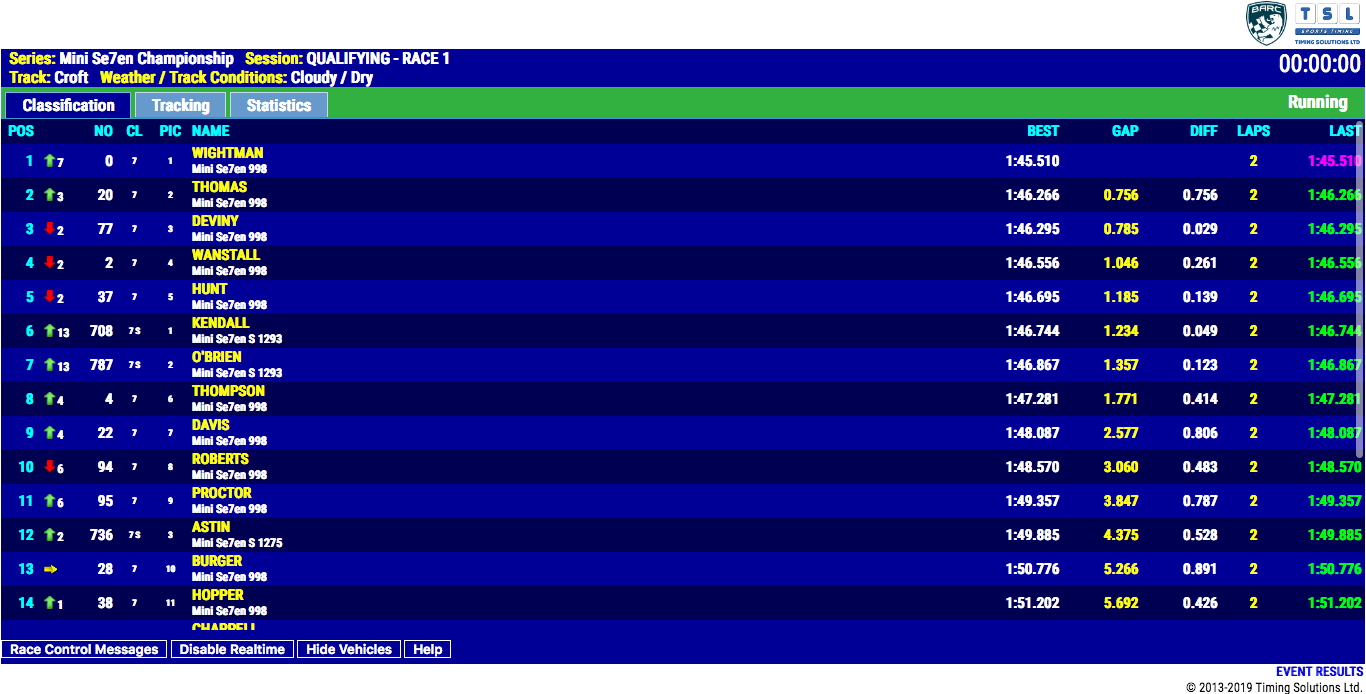

'screenshot_Classification.png'

In [92]:
#should perhap have a wait here to just make sure evrything is loaded...
#Or perhaps better, a guard at end of previous cell
setPageTab(browser, 'Classification')

In [96]:
import time

xpath = '//*[@id="ResultsTableContainer"]'


#This should really be while not finished
while True:
    #Grab the timing screen
    el = browser.find_element_by_xpath(xpath)
    
    #Parse out the data
    df = pd.read_html( el.get_attribute('innerHTML'))[0].dropna(axis=1,how='all')
    #Tidy up the column names
    df.rename(columns={'Time/Gap':'Gap',
                       'Unnamed: 1':'Penalties'}, inplace=True)
    #Upsert the date
    #DB[_table].upsert_all(df.to_dict(orient='records'))
    #insert the date
    DB[_table].insert_all(df.to_dict(orient='records'))
    print('.',end='')
    time.sleep(15)
    
#TO DO - also record time stamp; and maybe in another table, flag status vs timestamp
#so then we can easily retrieve eg approximate safety car periods etc

..........................................................

KeyboardInterrupt: 

I need to rethink the logic...

We need to grab the timing screen just after a car has lapped; at this point, the sector times will be the sector times from the previous lap.


Thinking this through: we need to sample at a rate less than the min sector time to grab all the sector time data. To capture the gap data, we need to sample between the last car on the lead lap and the leader (this makes sure we have a full column of times). Or we just forgo the Gap as noise? What's important is that we get the lap and sector times? Which is the first sampling of the row for a particular (vehicle number / lap) key pair.

When the leader laps, the other cars show `1 Lap` in the `Gap` column. When one of those car laps, we want to capture it. The unique key is the car number, and the lap number. When a car completes a lap, all the sector times are in place, lap counter increments and so does the last lap time. So we don't need an upsert. We need to add the new PK key and ignore any other updates.

To get sector times, we only need to sample with a period less than the minimum sector time. To grab the correct gap to leader time, the sample for a driver on a given lap has to be made while they are on the lead lap. The diff should always be correct?

So need to check the df to see if the PK is already taken, and if it is, don't add the row.

In [68]:
dbname='testlive4.db'

#!rm $dbname
conn = sqlite3.connect(dbname, timeout=10)

q="SELECT * FROM tsl_timing_classification;"
pd.read_sql(q,conn)

,Pos,Penalties,No,Cl,PIC,Name,Laps,TimeGap,Diff,Best,Last,PS,S1,V1,S2,V2,S3,VF
0,2,Penalties +0 seconds +0 position +0 lap +0...,5,None,None,FOLCH-RUSINOL (AUB) Ford GT40,7,1 Lap,1 Lap,1:24.861,1:24.861,NaN,25.882,129.3,35.931,154.9,None,NaN
1,3,Penalties +0 seconds +0 position +0 lap +0...,4,None,None,DAVIES (MET) Ford GT40,7,1 Lap,1.026,1:25.084,1:25.084,NaN,25.922,132.3,35.274,154.9,None,NaN
2,4,Penalties +0 seconds +0 position +0 lap +0...,14,None,None,HUGENHOLTZ (MET) Ford GT40,7,1 Lap,0.455,1:25.164,1:25.164,NaN,25.819,129.5,35.715,148.7,None,NaN
3,5,Penalties +0 seconds +0 position +0 lap +0...,25,None,None,HIBBERD (TOR) Lotus-Ford 23B,7,1 Lap,0.661,1:25.205,1:25.205,NaN,26.222,137.5,35.884,135.2,None,NaN
4,6,Penalties +0 seconds +0 position +0 lap +0...,7,None,None,GOODWIN (DAR) Lotus-Ford 23B,7,1 Lap,1.129,1:23.598,1:23.598,NaN,26.053,137.2,35.167,139.8,None,NaN
5,7,Penalties +0 seconds +0 position +0 lap +0...,2,None,None,FENNELL (AUB) Lotus-Ford 23B,7,1 Lap,8.605,1:27.045,1:27.045,NaN,26.967,132.6,36.316,134.2,None,NaN
6,24,Penalties +0 seconds +0 position +0 lap +0...,6,None,None,HEACOCK (AUB) Penske Zerex Special,6,2 Laps,1 Lap,1:37.151,1:38.007,NaN,30.112,116.5,41.275,126.6,None,NaN
7,8,Penalties +0 seconds +0 position +0 lap +0...,3,None,None,OWEN (TOR) Elva-BMW Mk7S,7,1 Lap,1 Lap,1:28.108,1:28.411,NaN,26.872,115.7,37.271,142.1,None,NaN
8,9,Penalties +0 seconds +0 position +0 lap +0...,36,None,None,BRUSCHNIK (TOR) Porsche 910,7,1 Lap,1.174,1:28.110,1:28.497,NaN,28.919,124.2,36.924,135.8,None,NaN
9,10,Penalties +0 seconds +0 position +0 lap +0...,23,None,None,KUBOTA (TOR) Lotus-Ford 23B,7,1 Lap,0.253,1:27.596,1:28.201,NaN,27.473,121.3,36.6,139.2,None,NaN


In [299]:
#Preferred time format
def formatTime(t):
    return float("%.3f" % t)

# Accept times in the form of hh:mm:ss.ss or mm:ss.ss
# Return the equivalent number of seconds and milliseconds
def getTime(ts, ms=False):
    ts=str(ts)
    t=ts.strip()
    if t=='': return pd.to_datetime('')
    if ts=='P': return None
    if 'LAP'.lower() in ts.lower():
        ts=str(1000*int(ts.split(' ')[0]))
    t=ts.split(':')
    if len(t)==3:
        tm=60*int(t[0])+60*int(t[1])+float(t[2])
    elif len(t)==2:
        tm=60*int(t[0])+float(t[1])
    else:
        tm=float(t[0])
    if ms:
        #We can't cast a NaN as an int
        return float(1000*formatTime(tm))
    return float(formatTime(tm))

In [300]:
df['LastInS']=df['Last'].apply(getTime)
df['BestInS']=df['Best'].apply(getTime)
df.head()

,Pos,Penalties,No,Cl,PIC,Name,Laps,TimeGap,Diff,Best,Last,PS,icons,LastInS
0,1,Penalties +0 seconds +0 position +0 lap +0...,48,Mig,1,DEEGAN Mini Miglia 1275,13,20:36.644,NaN,1:33.705,1:34.377,NaN,posIconFinished,94.377
1,2,Penalties +0 seconds +0 position +0 lap +0...,1,Mig,2,SMITH Mini Miglia 1293,13,0.354,0.354,1:33.789,1:34.779,NaN,posIconFinished,94.779
2,3,Penalties +0 seconds +0 position +0 lap +0...,11,Mig,3,ASTIN Mini Miglia 1293,13,2.501,2.147,1:33.865,1:35.275,NaN,posIconFinished,95.275
3,4,Penalties +0 seconds +0 position +0 lap +0...,23,Mig,4,DEETH Mini Miglia 1293,13,4.260,1.759,1:34.438,1:34.438,NaN,posIconFinished,94.438
4,5,Penalties +0 seconds +0 position +0 lap +0...,83,Mig,5,PEACOCK Mini Miglia 1293,13,4.712,0.452,1:34.171,1:34.598,NaN,posIconFinished,94.598


We can then easily save the dataframe to a CSV file:

In [62]:
df.to_csv('test1.csv')

#### Saving the Data to a Database
We can also save the data into a SQLite database.

There are several ways of doing this, of varying degrees of casulaness. The simplest way might be to create a separte table for each race (that is, each series and session combination) but that would explode the number of tables.

If we want to use fewer tables, then we need to know which series/session timing screens are alike (that is, have the same format / columns). It may be that all the sreens are the same, or it may be that practice, qualifying and race screens show different information. We would also need to check whether each series records the same columns in the timing screen if we are to have a single table for "race" data for example.

Also note that we would need to add some columns to the table if we are including data from mutliple series and/or sessions in the same table to identify which series/session any particular row in the table refers to.

In [68]:
import sqlite3
conn = sqlite3.connect("test.db")
df.to_sql('test1', con=conn, index=False, if_exists='replace')

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:2532: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


We can now query the data:

In [69]:
sql = 'SELECT * FROM test1 LIMIT 3'
pd.read_sql_query(sql, conn)

,Pos,Unnamed: 1,No,Cl,PIC,Name,Laps,Time/Gap,Diff,Best,Last,PS,S1,V1,S2,VF
0,1,Penalties +0 seconds +0 position +0 lap +0...,19,Pro,1,KING Elite Motorsport,22,22:06.736,None,54.088,54.491,None,32.373,99.8,22.118,120.2
1,2,Penalties +0 seconds +0 position +0 lap +0...,12,Pro,2,SOMERFIELD Privateer,22,8.663,8.663,54.527,55.593,None,32.920,97.8,22.673,119.8
2,3,Penalties +0 seconds +0 position +0 lap +0...,37,Pro,3,EPPS Team Hard,22,8.801,0.138,54.287,55.705,None,33.130,100.4,22.575,119.1


Note that we might also want to think about defining the database columns more formally if we know the structure of the timing screen data we want to record.

## Viewing Other Tabs

We can also grab data from tabs other than the *Classification* tab:

In [118]:
setPageTab(browser, 'Statistics')

MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=55081): Max retries exceeded with url: /session/1f337325-29a9-7241-87e2-0d1c2f868d84/element (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1097fcc50>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [55]:
#get statistics table
#//*[@id="StatsTableContainer"]/div[3]/div[2]/table
xpath = '//*[@id="StatsTableContainer"]/div[3]/div[2]/table'
el = browser.find_element_by_xpath(xpath)
el.text
#'Competitors: 30\nPlanned Start: 15:10\nActual Start: 15:25:00.510\nFinish Time:\nTotal Laps 107\nTotal Distance Covered: 129.2501 mi.\nTrack Length: 1.2079 mi.'

'Competitors: 0\nPlanned Start: 17:40\nActual Start:\nFinish Time:\nTotal Laps 0\nTotal Distance Covered: 0.0000 mi.\nTrack Length: 1.6404 mi.'

In [56]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,0,1
0,Competitors:,0
1,Planned Start:,17:40
2,Actual Start:,NaN
3,Finish Time:,NaN
4,Total Laps,0
5,Total Distance Covered:,0.0000 mi.
6,Track Length:,1.6404 mi.


In [53]:
#Flags table
xpath = '//*[@id="StatsTableContainer"]/div[3]/div[1]/table[1]'
el = browser.find_element_by_xpath(xpath)
el.text
#'COLOUR TOTAL TIME TOTAL LAPS COUNT\nGREEN 00:05:45 5 1\nRED 00:00:29 0 1\nSAFETY CAR 00:00:00 0 0\nFCY 00:00:00 0 0'

'COLOUR TOTAL TIME TOTAL LAPS COUNT\nGREEN 00:00:00 0 0\nRED 00:00:00 0 0\nSAFETY CAR 00:00:00 0 0\nFCY 00:00:00 0 0'

In [54]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,COLOUR,TOTAL TIME,TOTAL LAPS,COUNT
0,GREEN,00:00:00,0,0
1,RED,00:00:00,0,0
2,SAFETY CAR,00:00:00,0,0
3,FCY,00:00:00,0,0


In [50]:
#fastest laps
fastlap_path ='//*[@id="fastestLapTable"]'
el = browser.find_element_by_xpath(fastlap_path)
el.text
#'NO CL NAME TIME TIME OF DAY LAP AVG. SPEED (MPH) VEHICLE\n15\nM\nOLIPHANT * 54.140 15:29:02.984 4 80.32 BMW 330i M Sport\n116\nM\nSUTTON 54.685 15:28:24.626 3 79.52 Subaru Levorg\n25\nM\nNEAL 54.983 15:28:18.112 3 79.08 Honda Civic Type R\n1\nM\nTURKINGTON 55.127 15:28:07.375 3 78.88 BMW 330i M Sport\n303\nI\nSIMPSON 55.228 15:27:58.303 2 78.73 Honda CIvic Type R\n80\nM\nINGRAM 55.449 15:27:17.128 2 78.42 Toyota Corolla\n77\nM\nJORDAN 56.278 15:27:14.039 2 77.27 BMW 330i M Sport\n15\nM\nOLIPHANT * 56.858 15:27:13.242 2 76.48 BMW 330i M Sport\n1\nM\nTURKINGTON 57.049 15:27:12.248 2 76.22 BMW 330i M Sport'

'NO NAME TIME TIME OF DAY LAP AVG. SPEED (MPH) VEHICLE\n21\nLANDY 1:05.695 16:25:25.364 11 89.89 Caterham 310R\n88\nWALTERS 1:05.795 16:17:35.691 4 89.75 Caterham 310R\n74\nBEARDWELL 1:06.112 16:17:35.547 4 89.32 Caterham 310R\n77\nSAWYER 1:06.165 16:16:27.155 3 89.25 Caterham 310R\n91\nBRISTOW 1:06.235 16:15:21.702 2 89.16 Caterham 310R\n77\nSAWYER 1:06.319 16:15:20.980 2 89.04 Caterham 310R\n19\nHENSHALL 1:06.442 16:15:20.364 2 88.88 Caterham 310R'

In [52]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,NO,NAME,TIME,TIME OF DAY,LAP,AVG. SPEED (MPH),VEHICLE
0,21,LANDY,1:05.695,16:25:25.364,11,89.89,Caterham 310R
1,88,WALTERS,1:05.795,16:17:35.691,4,89.75,Caterham 310R
2,74,BEARDWELL,1:06.112,16:17:35.547,4,89.32,Caterham 310R
3,77,SAWYER,1:06.165,16:16:27.155,3,89.25,Caterham 310R
4,91,BRISTOW,1:06.235,16:15:21.702,2,89.16,Caterham 310R
5,77,SAWYER,1:06.319,16:15:20.980,2,89.04,Caterham 310R
6,19,HENSHALL,1:06.442,16:15:20.364,2,88.88,Caterham 310R


In [46]:
#leader history
leaderHistory_path = '//*[@id="leaderHistory"]/div/table'
el = browser.find_element_by_xpath(leaderHistory_path)
el.text
#NO NAME FROM LAP LAPS LED DISTANCE (MILES) VEHICLE\n19\nHENSHALL 6 1 1.64 Caterham 310R\n77\nSAWYER 4 2 3.28 Caterham 310R\n25\nMCCORMACK 2 2 3.28 Caterham 310R\n11\nPERRY 1 1 1.64 Caterham 310R

'NO NAME FROM LAP LAPS LED DISTANCE (MILES) VEHICLE\n77\nSAWYER 9 2 3.28 Caterham 310R\n19\nHENSHALL 8 1 1.64 Caterham 310R\n77\nSAWYER 7 1 1.64 Caterham 310R\n19\nHENSHALL 6 1 1.64 Caterham 310R\n77\nSAWYER 4 2 3.28 Caterham 310R\n25\nMCCORMACK 3 1 1.64 Caterham 310R\n19\nHENSHALL 2 1 1.64 Caterham 310R\n11\nPERRY 1 1 1.64 Caterham 310R'

In [48]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,NO,NAME,FROM LAP,LAPS LED,DISTANCE (MILES),VEHICLE
0,77,SAWYER,12,1,1.64,Caterham 310R
1,25,MCCORMACK,11,1,1.64,Caterham 310R
2,77,SAWYER,9,2,3.28,Caterham 310R
3,19,HENSHALL,8,1,1.64,Caterham 310R
4,77,SAWYER,7,1,1.64,Caterham 310R
5,19,HENSHALL,6,1,1.64,Caterham 310R
6,77,SAWYER,4,2,3.28,Caterham 310R
7,25,MCCORMACK,3,1,1.64,Caterham 310R
8,19,HENSHALL,2,1,1.64,Caterham 310R
9,11,PERRY,1,1,1.64,Caterham 310R


Create a function to grab statistcs tab data.

In [ ]:
def statisticsScreenToDB(browser, DB, _table='test_stats'):
    pass

screenshot saved to Santander Caterham Seven 310R Championship_RACE 5.png


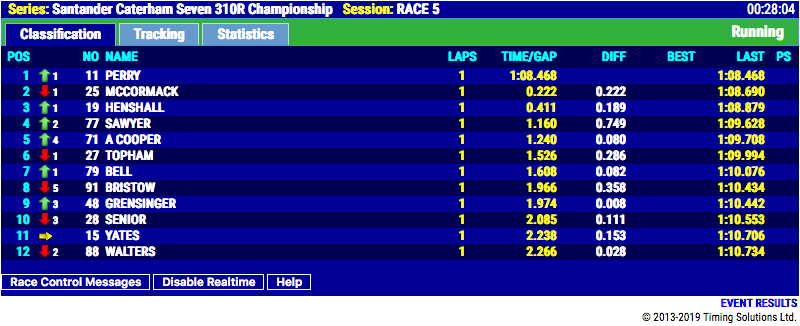

'Santander Caterham Seven 310R Championship_RACE 5.png'

In [24]:
#get file name
fn = '{}_{}.png'.format(series, session )

setPageTab(browser, 'Classification', fn)

In [19]:
#Doesn't work?
trackDisplayName_path ='//*[@id="weatherConditions"]/span[2]'
trackDisplayName = text_value_from_xpath(browser, trackDisplayName_path )
trackDisplayName

''

In [20]:
#Doesn't work?
weatherConditions_xpath = '//*[@id="weatherConditions"]/span[4]'
weatherConditions = text_value_from_xpath(browser, weatherConditions_xpath )
weatherConditions

''

In [21]:
#Doesn't work?
trackConditions_xpath = '//*[@id="weatherConditions"] '
trackConditions = text_value_from_xpath(browser, trackConditions_xpath )
trackConditions

''

## Automated Grab

The aim here is to grab a copy of the screen classification when the race has finished.

(How is finished flagged? Eg if the clock has reached zero do cars get to finish the lap they are on? At what point does "FINISHED" appear?)

*(If we want to run browsers over several timing screens, eg for different meetings on the same day, it may be worth looking to something like https://github.com/micahscopes/nbmultitask so we could launch several watchers, one per timing screen, in separate, non-blocking processes.)*

In [ ]:
#flag status is something like"

#FINISHED
#RUNNING
#RED FLAG
#Scheduled Start: 16.55
#Safety Car

Set up the database:

In [198]:
def initDb(dbname='test.db'):
    dbname='new_testlive2.db'
    
    #TO DO: change to py fn
    #!rm $dbname
    
    conn = sqlite3.connect(dbname, timeout=10)

    #Setup database tables
    c = conn.cursor()
    c.executescript(classification_table)


    DB = Database(conn)
    _table = 'tsl_timing_classification'
    
    return DBconn

In [141]:
def timingScreenToDB(browser, DB, _table='testTable'):#, period=15):

    xpath = '//*[@id="ResultsTableContainer"]'

    #Grab the timing screen
    el = browser.find_element_by_xpath(xpath)

    #Parse out the data
    df = pd.read_html( el.get_attribute('innerHTML'))[0].dropna(axis=1,how='all')
    #Tidy up the column names
    df.rename(columns={'Time/Gap':'Gap',
                       'Unnamed: 1':'Penalties'}, inplace=True)
    
    #Get the icon status
    df['icons'] = getPosIcon(browser)['icons']
    #Upsert the date
    #DB[_table].upsert_all(df.to_dict(orient='records'))
    #insert the data - this assumes the insert conflict ignore definition on the table
    DB[_table].insert_all(df.to_dict(orient='records'))
    #print('.',end='')
    #time.sleep(period)

    #outfile='tmp.png'
    #browser.save_screenshot( outfile )
    #Can we get this to just update the same image?
    #display(Image(outfile))
    
    #TO DO - also record time stamp; and maybe in another table, flag status vs timestamp
    #so then we can easily retrieve eg approximate safety car periods etc

The timing screen goes into a blank state when waiting for a new race. We may need to refresh it every so often when waiting for a new race to start. Do this with: `browser.refresh()`

Note that if we do this we need to set a wait for the page to load before we try to work on it.

In [57]:
url_brscc = 'https://livetiming.tsl-timing.com/191431'
url_btcc='https://livetiming.tsl-timing.com/191403' #btcc april 6

In [58]:
browser.get(url_btcc)

In [162]:
url='https://livetiming.tsl-timing.com/191521'
#url='https://livetiming.tsl-timing.com/191531'


In [195]:
getInfo(browser)

{'series': 'Northern Saloons and Sports Car Championship',
 'session': 'QUALIFYING - RACE 5',
 'tablename': 'NORTHERN_SALOONS_AND_SPORTS_CAR__Q_R_5'}

In [163]:
_table= getInfo(browser)['tablename']
c.executescript(classification_table.format(_table=_table))

If there is a long wait to the next race, the timing screen reports a `Scheduled Start` time. We can compare the current time to the scheduled start time, and if there is a long wait, we could go to sleep for a bit...

So how can we work out how long to wait?

In [209]:
#What's the time now?
from datetime import datetime
n = datetime.now()
n

datetime.datetime(2019, 4, 13, 15, 42, 38, 979769)

In [ ]:
#What's the schedule start time?
from dateutil import parser
s = parser.parse("{} {} {} {}".format(n.year, n.month, n.day, '15:50'))
s

In [214]:
#What's the difference?
(s-n).seconds

441

In [238]:
n = datetime.now()
s = parser.parse("{} {} {} {}".format(n.year, n.month, n.day, '17:40'))
(s-n).days

-1

In [239]:
def waitTimeToStart(tts, delay=120):
    ''' Calculate a sensible sleep time given the cirrent time and the scheduled start time.
        The delay gives the time before the scheduled start time we're happy to sleep until.
    '''
    n = datetime.now()
    s = parser.parse("{} {} {} {}".format(n.year, n.month, n.day, tts))
    tts = (s-n)
    
    #If the time is after the scehduled start time, wait a minute...
    #Seems we donlt get negative seconds?
    if tts.days < 0: 
        return 60
    #If the time is within the presecribed delay period, no need for an extra wait
    elif tts.seconds<delay:
        return 0
    else:
        return (s-n).seconds - delay

screenshot saved to screenshot_Classification.png


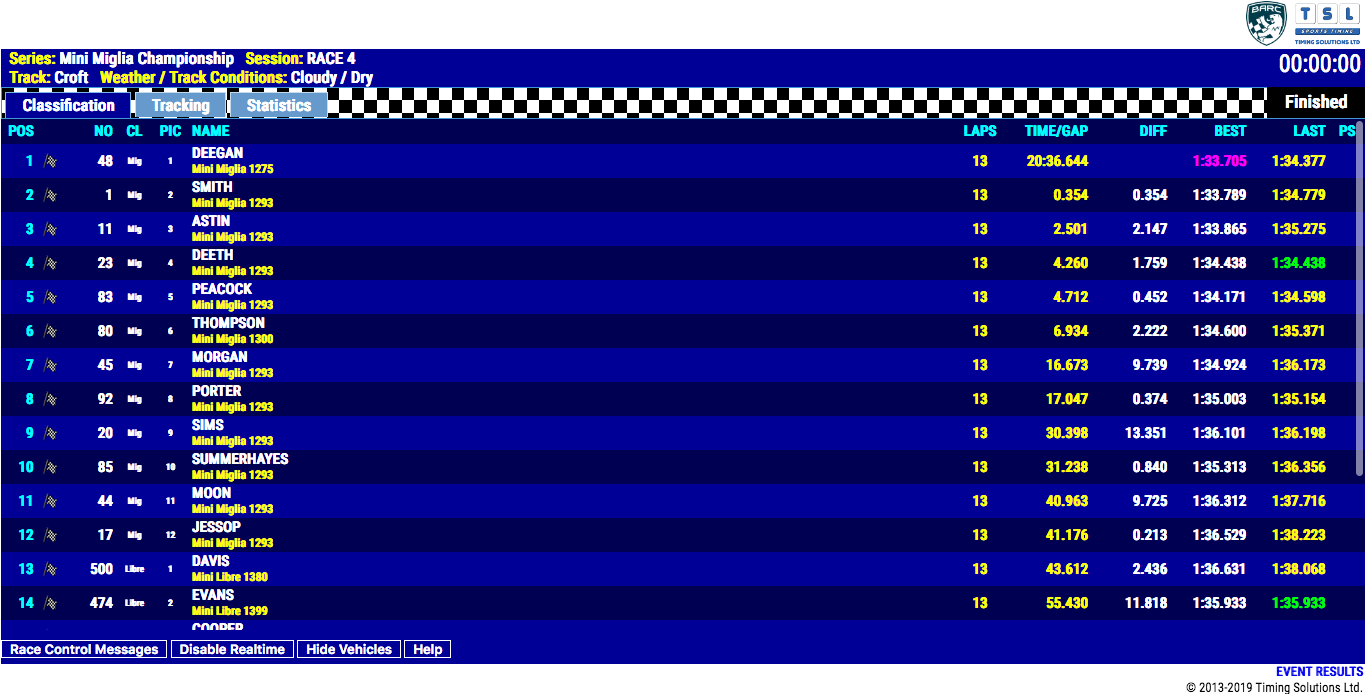

Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race
Still on screen from previous race


KeyboardInterrupt: 

In [245]:
import time

#Start to build up the logic

period=75
period_lap = 95 #This is the time we'll after we record the race as finished before declaring a result
#This means we declare a result at most period+period_lap after we first see FINISHED flag

finishedwait=60
refresh_before_scheduled_start = 120

#If we are in a race
browser = initBrowser(url)

showpreview=True
while True:
    
    #Reload the browser after each race
    browser = initBrowser(url)
    
    setPageTab(browser, 'Classification', preview=showpreview)

    flag = text_value_from_xpath(browser, flag_path )
    if flag.upper()=='FINISHED':
        print('Still on screen from previous race')
        time.sleep(finishedwait)
        showpreview=False
        continue
    showpreview=True
    
    #Start doing setup for a particular race here
    #Need to check we have a valid table name
    #If not, do a delay and then continue back to repeat the loop
    _table= getInfo(browser)['tablename']
    if not _table or _table=='':
        print('Nothing seems to be on the timing screen...Wait a couple of minutes...')
        wait(120)
        continue
    
    #If the scheduled start is some time away, wait until a few mins before the scheduled start
    #Or should we keep polling...
    #What happens over lunch? The previous table chekc should catch things there?
    
    #eg: Scheduled Start: 15.50 20:00
    if flag.startswith('Scheduled Start'):
        waitfor = waitTimeToStart(flag.replace('Scheduled Start','').split()[1],refresh_before_scheduled_start) 
        print('Race start {}; now {} so sleeping for {}s'.format(flag,datetime.now(),waitfor))
        time.sleep( waitfor )
        continue
    
    print("Creating table {} if it doesn't already exist".format(_table))
    c.executescript(classification_table.format(_table=_table))


    race_on = True if flag!='Finished' else False
    
    awaiting_result=True
    letsgoracing = True
    while race_on and awaiting_result:
        if letsgoracing:
            print('letsgoracing...')
            letsgoracing =False
            
        #Better to use some heuristics here eg based on time left in sessiontime
        #Only issue there is if a race is red flagged so is race clock/sessionTime?
        #So maybe try to grab close race start time, ish, and sessionTime at that point
        #and generate a heuristic about earliest time race is expected to finish?
        #For some reason, the flag doesn't seem to update in the browser properly?
        flag = text_value_from_xpath(browser, flag_path )
        timingScreenToDB(browser, DB, _table)
        print('.',end='')

        sessionTime = text_value_from_xpath(browser, sessionTime_path )
        print(flag, sessionTime, end='')
        while flag.upper()=='FINISHED':
            #We need to wait and do a final check - wait for time approx one lap
            #Get worst best lap time and use that? 
            time.sleep(period_lap)
            #Then need to get guaranteed final times
            #Need to guard that we do not do this if we have moved on to another race...
            flag = text_value_from_xpath(browser, flag_path )
            if flag.upper()=='FINISHED':
                timingScreenToDB(browser, DB, _table)
                #keep refreshing
                browser = initBrowser(url)
                setPageTab(browser, 'Classification', preview=False)
            print('Session should have completely finished...')
            awaiting_result = False
            #Also grab final classification table as a complete, separate thing
            #?need to create table?
            #timingScreenToDB(browser, DB, '{}_final_timing_screen'.format(_table))
            #setPageTab(browser, 'Statistics')
            #statisticsScreenToDB(browser, DB, '{}_final_statistics'.format(_table))
        else:
            #carry on waiting
            time.sleep(period)


fn = '{}_{}.png'.format(series, session )


#Don't need to get the URL? Just dump the screenshot instead?
#Browser is already good and if meeting is busy we may not be able to get a new connection onto timing screen?
#setPageTab(browser, 'Classification', fn)

browser.save_screenshot( fn )

In [171]:
sql = 'SELECT No, Name, Cl, MIN(Best) FROM {} WHERE Best IS NOT NULL GROUP BY No ORDER BY Cl, MIN(Best)'.format(_table)
pd.read_sql_query(sql, conn)

,No,Name,Cl,MIN(Best)
0,113,HARVEY Mini Libre 1380,Libre,1:37.027
1,500,DAVIS Mini Libre 1380,Libre,1:37.110
2,474,EVANS Mini Libre 1399,Libre,1:38.272
3,616,COOPER Mini Libre 1380,Libre,1:39.119
4,177,CREWES Mini Libre 1380,Libre,1:42.366
5,1,SMITH Mini Miglia 1293,Mig,1:34.272
6,80,THOMPSON Mini Miglia 1300,Mig,1:34.362
7,23,DEETH Mini Miglia 1293,Mig,1:34.511
8,11,ASTIN Mini Miglia 1293,Mig,1:34.772
9,83,PEACOCK Mini Miglia 1293,Mig,1:34.778


# Emailing the screenshot

Having grabbed the screenshot, we might now want to email it to somebody.

We can do that with the `smtplib` package if we have the details of an SMTP server we can connect to.

For example, if you have a GMail account:

In [44]:
import smtplib, ssl, getpass

port = 465  # For SSL

sender_email = input("Type your GMail address and press enter: ")
sender_password =  getpass.getpass()

# Create a secure SSL context
context = ssl.create_default_context()

receiver_email = "user@example.com"  # Enter receiver address
message = """\
Subject: Test

Test message from code..."""


with smtplib.SMTP_SSL("smtp.gmail.com", port, context=context) as server:
    server.login(sender_email, sender_password)
    server.sendmail(sender_email, receiver_email, message)

Type your GMail address and press enter: *******@gmail.com
········


In [46]:
subject='Test email attachment'
text = """some text
Over several

lines"""


In [50]:
#https://stackoverflow.com/a/3363254/454773
from os.path import basename
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.utils import COMMASPACE, formatdate

def send_mail(server, send_from, send_to, subject, text, files=None):
    assert isinstance(send_to, list)
    assert isinstance(files, list)

    msg = MIMEMultipart()
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    for f in files or []:
        with open(f, "rb") as fo:
            part = MIMEApplication(
                fo.read(),
                Name=basename(f)
            )
        # After the file is closed
        part['Content-Disposition'] = 'attachment; filename="%s"' % basename(f)
        msg.attach(part)


    #smtp = smtplib.SMTP(server)
    smtp = server
    smtp.sendmail(send_from, send_to, msg.as_string())
    smtp.close()


    
server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
server.login(sender_email, sender_password)
send_mail(server, sender_email, [receiver_email], subject, text, files=[outfile])

Sending with image inline as HTML email:

In [51]:
cid = 0 #A unique id count for the image

#We'd probably need to rething this for multiple images...
htmltext=''''<html><body><h1>Timing screen</h1>\n<div><img src="cid:{cid}"></div>\n</body></html>'''.format(cid=cid)

In [76]:
import uuid, datetime
from email.mime.base import MIMEBase
from email import encoders

#ish via https://www.code-learner.com/python-send-html-image-and-attachment-email-example/
def add_image(msg, img, iid=0):
    uniqueId = '{}-{}-{}'.format(img.split('/')[-1], datetime.datetime.now().strftime('%Y%m%d%H%M%S'), uuid.uuid4())
    
    with open(outfile, 'rb') as f:
        # set attachment mime and file name, the image type is png
        mime = MIMEBase('image', 'png', filename=img)
        # add required header data:
        mime.add_header('Content-Disposition', 'attachment', filename=img)
        mime.add_header('X-Attachment-Id', str(iid))
        mime.add_header('Content-ID', '<{}>'.format(iid))
        # read attachment file content into the MIMEBase object
        mime.set_payload(f.read())
        # encode with base64
        encoders.encode_base64(mime)
        # add MIMEBase object to MIMEMultipart object
        msg.attach(mime)
    
def send_mail_html(server, send_from, send_to, subject, text, htmltext, files=None):
    assert isinstance(send_to, list)
    assert isinstance(files, list)

    msg = MIMEMultipart('alternative')
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    fid=0
    for f in files or []:
        add_image(msg, f, fid)
        fid += 1
    msg.attach(MIMEText(htmltext, 'html', 'utf-8'))


    #smtp = smtplib.SMTP(server)
    smtp = server
    smtp.sendmail(send_from, send_to, msg.as_string())
    smtp.close()
    


In [77]:
server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
server.login(sender_email, sender_password)
send_mail_html(server, sender_email, [receiver_email], subject, text, htmltext, files=[outfile])

## TO DO

On the emailer:

- tidy it up so there's a reasonable way of adding multiple images to HTML email and getting the IDs right...

On the screengrabber:

- keep checking the page, parsing it to look for when a session is complete, then send an email of the final classification etc.

*I'm not sure if this would require reloading the page or whether the socket connection to the live timing server works and selenium can just keep rechecking for when a particular id takes a `FINISHED` value?*